# Plant and author distributions
Code to generate figure demonstrating the relationship between desiccation plant distribution and author locations.

In [94]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
from collections import defaultdict, Counter
import plotly.express as px
import pycountry
import pycountry_convert as pc
import numpy as np
import jsonlines
import sys
sys.path.append('../desiccation_network/conference_recommendation/')
import utils
import taxoniq
import networkx as nx
import json
from ast import literal_eval
from countryinfo import CountryInfo
from unidecode import unidecode
import requests
from functools import reduce
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import mannwhitneyu, chi2, false_discovery_control
from sklearn.preprocessing import StandardScaler

## Read in data

In [95]:
attendees = pd.read_csv('../data/conference_data/combined_attendees_2016_2024_with_Kingdom.csv')

In [96]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_ALL_with_authors_and_addresses_14Feb2024.jsonl') as reader:
    all_papers = [obj for obj in reader]

In [97]:
classed_network = nx.read_graphml('../data/citation_network/FINAL_FINAL_DEBUGGED_MANUALLY_VERIFIED_core_collection_destol_or_anhydro_classified_network_29Mar2024.graphml')

In [98]:
spec_occ = pd.read_csv('../data/conference_data/species_occ.csv', encoding_errors='replace')
spec_occ.head()

,sp_id,institutionCode,catalogNumber,countryCode,decimalLongitude,decimalLatitude,source
0,aaa023,PERTH,PERTH 3249093,AUS,116.083333,-34.766667,https://www.gbif.org/
1,aaa023,PERTH,PERTH 5453119,AUS,117.270833,-34.851389,https://www.gbif.org/
2,aaa023,PERTH,PERTH 6905811,AUS,117.016667,-34.516667,https://www.gbif.org/
3,aaa023,PERTH,PERTH 5900085,AUS,115.083333,-33.750000,https://www.gbif.org/
4,aaa023,PERTH,PERTH 3248895,AUS,115.938056,-34.508056,https://www.gbif.org/


In [99]:
spec_names = pd.read_csv('../data/conference_data/species_list.csv', encoding_errors='replace')
spec_names.head()

,sp_id,Family,Species,Taxonomic authority,Taxonomic observations,Cited as DT by
0,aaf003,Anemiaceae,Anemia ferruginea,Kunth,NaN,Ibisch et al. (1995)
1,aaf019,Anemiaceae,Anemia flexuosa,(Savigny) Sw.,NaN,Meirelles et al. (1997)
2,aax231,Anemiaceae,Anemia mexicana,Klotzsch,NaN,"Kessler & Siorak (2007), Mkhize (2018)"
3,aar329,Anemiaceae,Anemia rotundifolia,Schrad.,NaN,"Kessler & Siorak (2007), Derzhavina (2017), Mk..."
4,aat020,Anemiaceae,Anemia tomentosa,(Savigny) Sw.,NaN,"Gaff (1987), Kessler & Siorak (2007), Hietz (2..."


We want to filter our coordinates such that we only have angiosperms present in our dataset. To do this, we can use taxoniq again to get the classification of these species, and keep only those that are angiosperms (Magnoliopsida in NCBI Taxonomy).

In [100]:
fams_to_keep = []
for family in spec_names['Family'].unique():
    t1 = taxoniq.Taxon(scientific_name=family)
    lineage = [t.scientific_name for t in t1.ranked_lineage]
    if 'Magnoliopsida' in lineage:
        fams_to_keep.append(family)

In [101]:
spec_ids_to_keep = spec_names[spec_names['Family'].isin(fams_to_keep)]['sp_id'].unique()

In [102]:
spec_occ_angio = spec_occ[spec_occ['sp_id'].isin(spec_ids_to_keep)]
spec_occ_angio.head()

,sp_id,institutionCode,catalogNumber,countryCode,decimalLongitude,decimalLatitude,source
17075,bbc342,PERTH,PERTH 9296301,AUS,115.083333,-33.833333,https://www.gbif.org/
17076,bbc342,PERTH,PERTH 1964550,AUS,121.166667,-32.883333,https://www.gbif.org/
17077,bbc342,PERTH,PERTH 6190332,AUS,116.016667,-32.166667,https://www.gbif.org/
17078,bbc342,PERTH,PERTH 1954776,AUS,122.513056,-33.326389,https://www.gbif.org/
17079,bbc342,PERTH,PERTH 2465175,AUS,119.666667,-33.083333,https://www.gbif.org/


In [103]:
print(f'There are {len(spec_occ_angio.sp_id.unique())} unique resurrection angiosperms in our dataset')

There are 134 unique resurrection angiosperms in our dataset


## Basic visualizations

### Number of observations per species
Of angiosperm resurrection plants

<Axes: xlabel='decimalLongitude', ylabel='Density'>

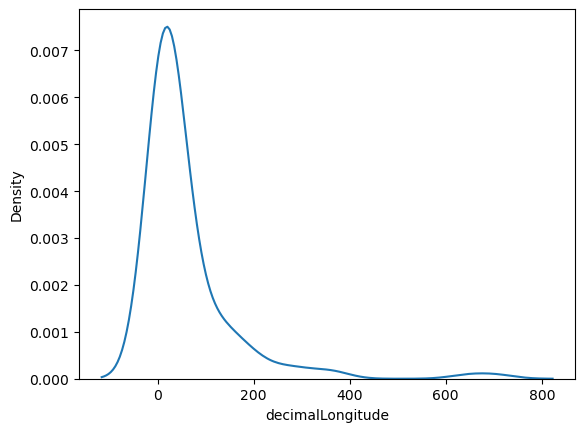

In [104]:
sns.kdeplot(spec_occ_angio.groupby('sp_id').count()['decimalLongitude'])

### All individual plant observations
Each point is one observation of an angiosperm resurrection plant.

/tmp/local/33224491/ipykernel_249811/1985845483.py:4: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



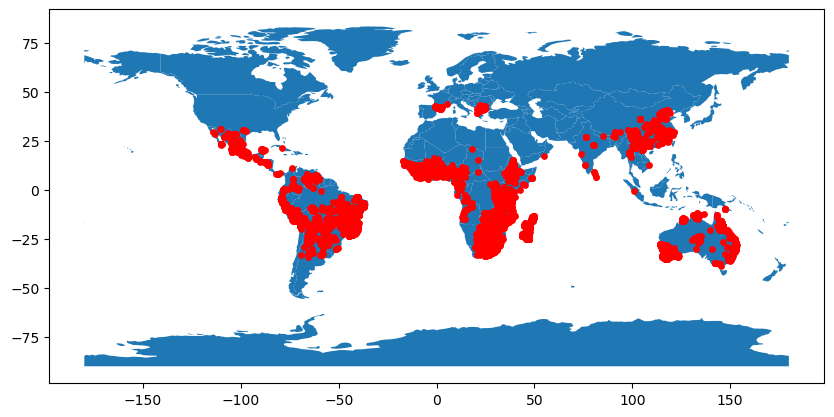

In [105]:
geometry = [Point(xy) for xy in zip(spec_occ_angio['decimalLongitude'], spec_occ_angio['decimalLatitude'])]
gdf = GeoDataFrame(spec_occ_angio[['decimalLatitude', 'decimalLongitude']], geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

## Publication representation per plant visualizations
In this section, our goal is to answer the following questions:

1. How well-represented is each country in the desiccation tolerance publication dataset as compared to the unmber of unique resurrection plant species found in that country?
2. In the conference author dataset?
3. Are those two sets of representations the same or different?

In short, we want to justify using a geographic factor in the conference recommendation system. Anecdotally, scientists have observed that countries with high resurrection plant diversity have low representation at DesWorks. What we want to know is, can we remedy that problem by choosing authros from those countries, or is there a larger representation issue that prevents us from effectively leveraging the literature to suggest nominees based on geography? If the two distributions are not significantly different, we can't count on the literature to help us.

To perform this analysis, we'll do the following:
1. Map the number of unique resurrection plant species in each country (normalized by Area)
2. Get the number of Plant publications from each country in the full dataset (normalized by Population)
    1. Use chi-squared test to determine if the number is different from the expected number
3. Get the number of Plant conference attendees (manual labeling) from each country
    1. Use chi-squared test to determine if the number is different from the expected number
4. For both (2) and (3), calculate representation per country using the following:

$$\frac{\frac{\text{# Publications}}{\text{Population}}}{\frac{\text{# Resurrection plants}}{\text{Area}}}$$

5. Compare the distributions of representation values between conference authors and full-dataset authors using a t-test to determine significance.

### Pre-process list of countries to track
Rather than only track countries that have plants or papers (which are overlapping but non-identical sets), we're going to start with a list of countries that we will get information for, including countries that have both 0 plant and 0 paper counts. We'll use the combination of the Natural Earth `lowres` and `tiny_points` datasets to get this list.

In [106]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries_large = world[['iso_a3']]
countries_large.head()

/tmp/local/33224491/ipykernel_249811/3925716115.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,iso_a3
0,FJI
1,TZA
2,ESH
3,CAN
4,USA


In [107]:
mini_world = gpd.read_file('../data/ne_110m_admin_0_tiny_countries.zip')
countries_mini = mini_world[['SOV_A3']]
countries_mini = countries_mini.rename(columns={'SOV_A3': 'iso_a3'})
countries_mini.head()

,iso_a3
0,VUT
1,FR1
2,GB1
3,NZ1
4,WSM


In [108]:
all_countries = countries_large.merge(countries_mini, how='outer')
all_countries = all_countries.rename(columns={'iso_a3': 'iso_alpha'}).drop_duplicates()
all_countries.head()

,iso_alpha
0,FJI
1,TZA
2,ESH
3,CAN
4,USA


In [109]:
print(f'There are {len(all_countries)} countries to track.')

There are 198 countries to track.


### Pre-process conference authors
Here, we'll remove any conference attendees that are not in the Plant domain and get the number of authors per country, as well as normalize for population.

In [110]:
unique_attendees = attendees.drop_duplicates(subset=['Surname', 'First_name'], ignore_index=True).sort_values('Surname')
print(f'There are {len(unique_attendees)} unique attendees.')

There are 113 unique attendees.


For a few of the attendees, we couldn't identify them uniquely in online databases to find their research specialty, so we have to drop them, as well as those who don't have Plant as one of their Kingdoms.

In [111]:
unique_attendees = unique_attendees.dropna(subset='Kingdom')
unique_attendees = unique_attendees[unique_attendees['Kingdom'].str.contains('Plant')]
print(f'After dropping individuals with no Kingdom or a Kingdom not including Plant, there are {len(unique_attendees)} individuals.')

After dropping individuals with no Kingdom or a Kingdom not including Plant, there are 102 individuals.


In [112]:
# So that we can use the country conversions below
unique_attendees = unique_attendees.replace({'The Netherlands': 'Netherlands', 'USA': 'United States'})

Get the country codes for all countries:

In [113]:
country_conversions = {country.name: country.alpha_3 for country in pycountry.countries}

In [114]:
country_counts = pd.DataFrame(unique_attendees['Country'].value_counts(), columns=['count']).rename(columns={'count': 'conf_auth_count'})
country_counts['iso_alpha'] = country_counts.index.map(country_conversions)
country_counts.head()

,conf_auth_count,iso_alpha
Country,,
South Africa,36,ZAF
United States,14,USA
Israel,8,ISR
Netherlands,7,NLD
Germany,7,DEU


Merge with the list of countries to track, and fill any `NaN` with 0:

In [115]:
country_counts = country_counts.merge(all_countries, on='iso_alpha', how='outer').fillna(0)
country_counts.head()

,conf_auth_count,iso_alpha
0,36.0,ZAF
1,14.0,USA
2,8.0,ISR
3,7.0,NLD
4,7.0,DEU


In [116]:
country_counts.shape

(198, 2)

We'll Use the World Bank API to get the population numbers, with code from [this blog](https://medium.com/@brechtcorbeel/analyzing-global-population-data-with-python-and-the-world-bank-api-1411e10c6484):

In [117]:
# Define the URL for the API request
url = "http://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?date=2022&format=json&per_page=10000"
# Make the GET request to the World Bank API
response = requests.get(url)
# Convert the response to JSON
json_data = response.json()
# Convert the JSON data to a pandas DataFrame
pop_2022 = pd.json_normalize(json_data[1])
pop_2022.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,AFE,2022,720859132.0,,,0,SP.POP.TOTL,"Population, total",ZH,Africa Eastern and Southern
1,AFW,2022,490330870.0,,,0,SP.POP.TOTL,"Population, total",ZI,Africa Western and Central
2,ARB,2022,464684914.0,,,0,SP.POP.TOTL,"Population, total",1A,Arab World
3,CSS,2022,7505478.0,,,0,SP.POP.TOTL,"Population, total",S3,Caribbean small states
4,CEB,2022,100108221.0,,,0,SP.POP.TOTL,"Population, total",B8,Central Europe and the Baltics


In [118]:
pop_2022.shape

(266, 10)

Important to note is that the World Bank neither [counts Taiwan as its own country nor inclueds it in China's statistics](https://datahelpdesk.worldbank.org/knowledgebase/articles/114933-where-are-your-data-on-taiwan), so we lose Taiwan merging with the population dataframe we just obtained. To get statistics for Taiwan to add to our population dataframe before merging, we'll use [2022 statistics from the government of Taiwan](https://www.ris.gov.tw/app/en/2121?sn=23009515#:~:text=By%20the%20end%20of%20Dec,average%20daily%20decreased%20was%20303.2.) and manually add a row into the datarame. The population of Taiwan in 2022 was 23,264,640.

In [119]:
twn_pop = pd.DataFrame({'countryiso3code': ['TWN'], 'date': [2022],
           'value': [23264640.0], 'unit': [np.nan], 'obs_status': [np.nan],
           'decimal': [0], 'indicator.id': ['SP.POP.TOTL'],
           'indicator.value': ['Population, total'],
           'country.id': ['TW'], 'country.value': ['East Asia & Pacific']})
pop_2022 = pd.concat([pop_2022, twn_pop])
pop_2022.shape

(267, 10)

Merge with df and normalize:

In [120]:
conf_auth_w_pop = country_counts.merge(pop_2022, left_on='iso_alpha', right_on='countryiso3code', how='left')
conf_auth_w_pop = conf_auth_w_pop.drop(columns=['countryiso3code', 'date', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value']).fillna(0)
conf_auth_w_pop = conf_auth_w_pop.rename(columns={'value': 'population'})
conf_auth_w_pop.head()

,conf_auth_count,iso_alpha,population
0,36.0,ZAF,59893885.0
1,14.0,USA,333287557.0
2,8.0,ISR,9557500.0
3,7.0,NLD,17700982.0
4,7.0,DEU,83797985.0


In [121]:
conf_auth_w_pop.shape

(198, 3)

### Pre-process all authors in dataset
Here, we'll calculate the number of papers per country and remove any that are not Plants. We'll also normalize number of papers by each country's population.

First, we need to process the authors and addresses from all papers in the dataset. For the purposes of this exercise, we will assume anyone with the same WOS standard name is the same person. We don't want to double count papers, so we'll only look at the corresponding author to associate each paper with a country.

In [122]:
missing_addresses = []
no_addr_no_mult_countries = []
for paper in all_papers:
    if len(paper['addresses']) == 0:
        missing_addresses.append(paper['UID'])
    try:
        addr_nos = [author['addr_no'] for author in paper['authors']]
        has_addr_no = True
    except KeyError:
        has_addr_no = False
    all_author_countries = [addr['country'] for addr in paper['addresses']]
    if (len(set(all_author_countries)) > 1) and not has_addr_no:
        no_addr_no_mult_countries.append(paper['UID'])
print(f'There are {len(missing_addresses)} papers that don\'t have geographic information.')
print(f'There are {len(no_addr_no_mult_countries)} papers that don\'t have addr_no\'s for their authors and also have more than one country in the addresses')

There are 282 papers that don't have geographic information.
There are 524 papers that don't have addr_no's for their authors and also have more than one country in the addresses


In [123]:
papers_by_uid = {p['UID']: p for p in all_papers}
no_geo_authors = []
for puid in missing_addresses + no_addr_no_mult_countries:
    for author in papers_by_uid[puid]['authors']:
        no_geo_authors.append(author['wos_standard'].lower())
print(f'There are {len(set(no_geo_authors))} unique authors that may not have geographical affiliations in our dataset.')

There are 2216 unique authors that may not have geographical affiliations in our dataset.


In [124]:
authors2countries = utils.get_geographic_locations(all_papers)

There are 16614 author-country pairs, and 18036 total authors.


In [125]:
paper_countries = defaultdict(list)
for paper in all_papers:
    authors_with_emails = []
    for author in paper['authors']:
        if 'email_addr' in author.keys():
            authors_with_emails.append(author)
    # If there are multiple authors with emails and their countries are different, pick the majority one
    corr_author_countries = []
    for author in authors_with_emails:
        try:
            corr_author_countries.append(authors2countries[author['wos_standard'].lower()])
        except KeyError:
            continue
    if len(set(corr_author_countries)) == 1:
        paper_countries[corr_author_countries[0]].append(paper['UID'])
    elif len(set(corr_author_countries)) > 1:
        max_country = Counter(corr_author_countries).most_common()[0][0]
        paper_countries[max_country].append(paper['UID'])

In [126]:
print(f'{sum([len(val) for val in paper_countries.values()])} of {len(all_papers)} papers had a location recovered.')

5409 of 6903 papers had a location recovered.


In [127]:
print(f'There are {len(paper_countries)} unique countries represented in the full desiccation tolerance dataset')

There are 85 unique countries represented in the full desiccation tolerance dataset


We also need to remove any papers that are not Plant papers:

In [128]:
study_systems = nx.get_node_attributes(classed_network, 'study_system')
papers_dropped = {'uid': [], 'noclass': []}
system_paper_geos = {
    'Plant': defaultdict(list),
    'Animal': defaultdict(list),
    'Microbe': defaultdict(list),
    'Fungi': defaultdict(list)
}
for country, paper_uids in paper_countries.items():
    for uid in paper_uids:
        try:
            system = study_systems[uid]
            system_paper_geos[system][country].append(uid)
        except KeyError as e:
            if str(e)[1:-1] == 'NOCLASS':
                papers_dropped['noclass'].append(uid)
            elif str(e)[1:-1] == uid:
                papers_dropped['uid'].append(uid)
            continue

In [129]:
print(f'{len(papers_dropped["uid"])} papers were missing from the classification datatset and were dropped, while '
     f'{len(papers_dropped["noclass"])} papers had no Kingdom and were dropped.')

1267 papers were missing from the classification datatset and were dropped, while 0 papers had no Kingdom and were dropped.


In [130]:
sys_dfs = {}
for sys, locs in system_paper_geos.items():
    counts = {key: len(val) for key, val in locs.items()}
    counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).reset_index().rename(columns={'index':'iso_alpha', 'count': 'paper_count'})
    sys_dfs[sys] = counts_df
plant_paper_counts = sys_dfs['Plant']
plant_paper_counts.head()

,iso_alpha,paper_count
0,FRA,80
1,USA,366
2,ZAF,118
3,JPN,79
4,DEU,155


In [131]:
print(f'There are {len(plant_paper_counts)} countries represented in the Plant subset of the desiccation tolerance dataset.')

There are 75 countries represented in the Plant subset of the desiccation tolerance dataset.


We also want to add 0's for countries with no papers to maintain a complete dataset:

In [132]:
plant_paper_counts = all_countries.merge(plant_paper_counts, how='left').fillna(0)
plant_paper_counts.head()

,iso_alpha,paper_count
0,FJI,0.0
1,TZA,0.0
2,ESH,0.0
3,CAN,56.0
4,USA,366.0


In [133]:
plant_paper_counts.shape

(198, 2)

Merge population with paper counts df and normalize:

In [134]:
plant_paper_counts_pop = plant_paper_counts.merge(pop_2022, left_on='iso_alpha', right_on='countryiso3code', how='left')
plant_paper_counts_pop = plant_paper_counts_pop.drop(columns=['countryiso3code', 'date', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value'])
plant_paper_counts_pop = plant_paper_counts_pop.rename(columns={'value': 'population'})
plant_paper_counts_pop.head()

,iso_alpha,paper_count,population
0,FJI,0.0,929766.0
1,TZA,0.0,65497748.0
2,ESH,0.0,NaN
3,CAN,56.0,38929902.0
4,USA,366.0,333287557.0


In [135]:
plant_paper_counts_pop.shape

(198, 3)

We also want to add the country affiliation information per-paper to our classification network so that we can visualize connections across countries and continents. We'll add two parameters: `country` and `continent`.

In [136]:
def country_to_continent(country_a3):
    """
    Adapted from https://stackoverflow.com/a/59166127/13340814
    """
    if country_a3 == 'XKX':
        return 'Europe'
    else:
        country_alpha2 = pc.country_alpha3_to_country_alpha2(country_a3)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name

In [137]:
country_attrs = {}
continent_attrs = {}
for country, paper_uids in paper_countries.items():
    ia3 = country
    for uid in paper_uids:
        country_attrs[uid] = ia3
        continent_attrs[uid] = country_to_continent(ia3)

In [138]:
geo_network = classed_network.copy()
nx.set_node_attributes(geo_network, country_attrs, name='country')
nx.set_node_attributes(geo_network, continent_attrs, name='continent')
nx.write_graphml(geo_network, '../data/citation_network/FINAL_FINAL_DEBUGGED_MANUALLY_VERIFIED_core_collection_destol_or_anhydro_classified_network_29Mar2024_with_geography.graphml')

### Pre-process plant information
Here we want to get the number of unique resurrection plant species in each country normalized by the area of the country.

First, we need to map each set of coordinates to a country:

In [139]:
latlons = defaultdict(list)
for i, row in spec_occ_angio.iterrows():
    latlons[row['sp_id']].append((row['decimalLatitude'], row['decimalLongitude']))
latlons = {k: list(set(v)) for k, v in latlons.items()}

In [140]:
print(f'There are {sum([len(v) for v in latlons.values()])} total observations, {len(set([coords for v in latlons.values() for coords in v]))} of them are unique.')

There are 5832 total observations, 5038 of them are unique.


In [141]:
unique_coords = list(set([coords for v in latlons.values() for coords in v]))

Given the large volume of coordinates, this mapping procedure is quite time consuming (~7h for all unique coordinates). Therefore, we'll submit the following code as a job:

In [142]:
# geolocator = Nominatim(user_agent="desiccation")

In [143]:
# observation_countries = {}
# for coord in tqdm(unique_coords):
#     address = geolocator.reverse(coord)
#     country = address.raw['address']['country']
#     observation_countries[coord] = country

In [144]:
# coords_country_df = pd.read_csv()

Now we can read back in the countries we got:

In [145]:
with open('../data/conference_data/species_countries.json') as myf:
    coord2country = json.load(myf)

In [146]:
coord2country = {literal_eval(k):v for k, v in coord2country.items()}

In [147]:
plant_countries = {}
for spec_id, coords_list in latlons.items():
    plant_ctrs = []
    for coords in coords_list:
        country = coord2country[coords]
        plant_ctrs.append(country)
    plant_countries[spec_id] = plant_ctrs

In [148]:
plant_countries = {k: list(set(v)) for k, v in plant_countries.items()}

Nominatim returns the country names in their official languages, so we need a map from official language country names to ISO codes. To do this, I used Excel to [scrape the table](https://www.analytics-tuts.com/download-tables-from-any-webpage-to-excel/) from the [Nominatim country codes wiki page](https://wiki.openstreetmap.org/wiki/Nominatim/Country_Codes), which we can use to make our conversions.

In [149]:
country_info = pd.read_excel('../data/conference_data/country_info.xlsx', header=1)
country_info = country_info.rename(columns={
    'ISO 3166-1_x000D_\ncountry code': 'iso_alpha2',
    'Country name_x000D_\n(English)': 'english_name',
    'Country name_x000D_\n(local)': 'local_names',
    'Default BCP 47 language codes _x000D_\n(usually from ISO 639-1, or ISO 639-3 otherwise)': 'languages'
})
country_info.head()

,iso_alpha2,english_name,local_names,languages
0,AD,Andorra,Andorra,ca
1,AE,United Arab Emirates,دولة الإمارات العربيّة المتّحدة,ar
2,AF,Afghanistan,"د افغانستان اسلامي دولتدولت اسلامی افغانستان, ...","fa, ps"
3,AG,Antigua and Barbuda,Antigua and Barbuda,en
4,AI,Anguilla,Anguilla,en


In [150]:
local2alpha2 = {}
for i, country_row in country_info.iterrows():
    for loc_name in country_row.local_names.split(', '):
        local2alpha2[loc_name] = country_row.iso_alpha2

In [151]:
two2three = {pc.country_alpha3_to_country_alpha2(thr): thr for thr in country_conversions.values()}

There are 20 countries that don't get identified by their names in the `plant_countries` dict, so we'll just manually define their mappings:

In [152]:
missing_country_map = {
 'Congo': 'COG',
 'Côte d’Ivoire': 'CIV',
 'Guinea Ecuatorial': 'GNQ',
 'Ködörösêse tî Bêafrîka / République centrafricaine': 'CAF',
 'Madagasikara / Madagascar': 'MDG',
 'Moçambique': 'MOZ',
 'Namibia': 'NAM',
 'Panamá': 'PAN',
 'Papua Niugini': 'PNG',
 'Paraguay / Paraguái': 'PRY',
 'République démocratique du Congo': 'COD',
 'Soomaaliya الصومال': 'SOM',
 'Tchad تشاد': 'TCD',
 'United States': 'USA',
 'Ελλάς': 'GRC',
 'عمان': 'OMN',
 'नेपाल': 'NPL',
 'ශ්\u200dරී ලංකාව இலங்கை': 'LKA',
 'འབྲུགཡུལ་': 'BTN', # Not sure if this is correct
 'ኤርትራ Eritrea إرتريا': 'ERI'
}

In [153]:
plant_iso = {}
for sp_id, clist in plant_countries.items():
    sp_iso = []
    for c in clist:
        try:
            sp_iso.append(two2three[local2alpha2[c]])
        except KeyError:
            sp_iso.append(missing_country_map[c])
    plant_iso[sp_id] = sp_iso

We now want to plot the number of unique species per country, so we want to flip the dictionary that we have, in addition to replacing their alphanumeric ID's with their species names.

In [154]:
iso_spec_names = defaultdict(list)
for sp_id, clist in plant_iso.items():
    sp_name = spec_names[spec_names['sp_id'] == sp_id]['Species'].unique()[0]
    for c in clist:
        iso_spec_names[c].append(sp_name)
iso_spec_names = {k: list(set(v)) for k, v in iso_spec_names.items()}

Format the data into a dataframe:

In [155]:
spec_counts = pd.DataFrame.from_dict({k: len(v) for k, v in iso_spec_names.items()}, orient='index', columns=['plant_count'])
spec_counts.index = spec_counts.index.rename('iso_alpha')
spec_counts = spec_counts.reset_index()
spec_counts.head()

,iso_alpha,plant_count
0,AUS,19
1,BRA,49
2,PER,4
3,BOL,10
4,BEN,6


In [156]:
print(f'There are {spec_counts.shape[0]} countries with plant counts.')

There are 72 countries with plant counts.


Important to note is that we have 72 countries with Plant papers, and 72 countries with plant counts, but that these 72 countries are not the same; we therefore need to put 0's in the `plant_count` column for all countries that don't have counts, to make sure they aren't dropped from the analysis.

In [157]:
all_country_plant_counts = all_countries.merge(spec_counts, how='outer').fillna(0)
all_country_plant_counts.head()

,iso_alpha,plant_count
0,FJI,0.0
1,TZA,23.0
2,ESH,0.0
3,CAN,0.0
4,USA,2.0


In [158]:
all_country_plant_counts.shape

(198, 2)

Now we need to get the area of each country and then normalize the plant counts. Unfortunately, countries that are in the `tiny_points` dataset jsut have an area of 0, so we'll fill those in with `NaN` when the time comes.

In [159]:
# Code from https://gis.stackexchange.com/a/218453
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(epsg=3035) # This is the right CRS according to https://stackoverflow.com/a/56789781
world['area_km2'] = world['geometry'].area/ 10**6
world.head()

/tmp/local/33224491/ipykernel_249811/777026806.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry,area_km2
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((7696097.606 14817308.230, 7730...",1.916776e+04
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((7252992.983 -2063289.921, 7274535.37...",9.335536e+05
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((2456834.289 747015.259, 2455500.781 ...",9.586239e+04
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((532141.344 9621825.205, 539625...",1.003334e+07
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((532141.344 9621825.205, 385209...",9.512162e+06


Merge with plant counts and normalize:

In [160]:
spec_counts_area = all_country_plant_counts.merge(world, left_on='iso_alpha', right_on='iso_a3', how='left').drop(columns=['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry']).fillna(0)
spec_counts_area.head()

,iso_alpha,plant_count,area_km2
0,FJI,0.0,1.916776e+04
1,TZA,23.0,9.335536e+05
2,ESH,0.0,9.586239e+04
3,CAN,0.0,1.003334e+07
4,USA,2.0,9.512162e+06


In [161]:
spec_counts_area.shape

(198, 3)

In [162]:
spec_counts_area['normalized_plant_count'] = spec_counts_area['plant_count']/spec_counts_area['area_km2']
spec_counts_area.head()

,iso_alpha,plant_count,area_km2,normalized_plant_count
0,FJI,0.0,1.916776e+04,0.000000e+00
1,TZA,23.0,9.335536e+05,2.463704e-05
2,ESH,0.0,9.586239e+04,0.000000e+00
3,CAN,0.0,1.003334e+07,0.000000e+00
4,USA,2.0,9.512162e+06,2.102571e-07


Let's get a quick visual of the distribution of plants. We need to replace 0's with None to make sure that they stay grey in this visualization -- the distribution of normalized counts is so skewed that 0 doesn't look different from other light colors for low numbers.

In [163]:
spec_counts_for_viz = spec_counts_area.copy()
spec_counts_for_viz.loc[spec_counts_for_viz['normalized_plant_count'] == 0.0, 'normalized_plant_count'] = None

In [164]:
fig = px.choropleth(spec_counts_for_viz, locations='iso_alpha', color='normalized_plant_count', color_continuous_scale=px.colors.sequential.algae)
fig.show()
fig.write_image('../data/citation_network/figures/normalized_resurrection_plant_distribution.pdf')

### Combine all pre-processed data into one dataframe
This way we have all the data in one convenient place.

In [165]:
all_counts = reduce(lambda left, right: pd.merge(left, right, how='inner', on='iso_alpha'), [conf_auth_w_pop, plant_paper_counts_pop, spec_counts_area]).drop(columns=['population_y', 'normalized_plant_count']).rename(columns={'population_x': 'population'})
all_counts.head()

,conf_auth_count,iso_alpha,population,paper_count,plant_count,area_km2
0,36.0,ZAF,59893885.0,118.0,16.0,1.216437e+06
1,14.0,USA,333287557.0,366.0,2.0,9.512162e+06
2,8.0,ISR,9557500.0,28.0,0.0,2.297568e+04
3,7.0,NLD,17700982.0,57.0,0.0,4.002133e+04
4,7.0,DEU,83797985.0,155.0,0.0,3.574253e+05


In [166]:
all_counts.shape

(198, 6)

Now that we have clean information for all countries, we want to drop any country that has 0 plants:

In [167]:
excluded_countries = all_counts[all_counts['plant_count'] == 0]
all_counts = all_counts[all_counts['plant_count'] > 0]

In [168]:
all_counts.head()

,conf_auth_count,iso_alpha,population,paper_count,plant_count,area_km2
0,36.0,ZAF,5.989388e+07,118.0,16.0,1.216437e+06
1,14.0,USA,3.332876e+08,366.0,2.0,9.512162e+06
5,5.0,FRA,6.797131e+07,80.0,1.0,6.448534e+05
6,3.0,ESP,4.777834e+07,89.0,1.0,5.023083e+05
7,3.0,IND,1.417173e+09,110.0,3.0,3.142890e+06


In [169]:
all_counts.shape

(72, 6)

### Statistics on representation
Before we compare the full dataset authors with the conference authors, we want to check if the number of publications/authors in each country matches what we would expect based on the number of unique resurrection plants found in that country. To do this, we want to test if the expected number of papers in each country is significantly different than what we observe. There are two factors we'll use to calculate the expected paper value: population, and resurrection plant distribution.

The calculation of expected paper count per country is the following:

$$\text{Expected paper count} = \frac{(\text{Country population} * \frac{\text{Total paper count}}{\text{Total population}})}{\text{Normalized country plant count}}$$

Differences in population are automatically accounted for in this calculation by using population to get the expected paper count. However, we also need to account for country area in the plant count, because the larger the area of a country, the more platns we expect to find. However, since the plant counts are so small, we can't directly use the normalized values, because they're too small. To get around this, we'll calculate the normalized values for all countries, and then scale them to a mean of 5 (in the same range as the actual plant counts) to be able to use them in our calculations.

We then use a chi-square loop, where we compare each country against all others.

In [170]:
all_counts['exp_papers'] = (all_counts['population']*(all_counts['paper_count'].sum()/all_counts['population'].sum()))

In [171]:
all_counts['normed_plant_count'] = all_counts['plant_count']/all_counts['area_km2']
scaler = StandardScaler(with_mean=False)
scaler.fit(all_counts['normed_plant_count'].to_numpy().reshape(-1, 1))
all_counts['scaled_normed_plant_count'] = scaler.transform(all_counts['normed_plant_count'].to_numpy().reshape(-1, 1)) + 5

In [172]:
all_counts['scaled_normed_plant_count'].min(), all_counts['scaled_normed_plant_count'].max()

(5.005464316556861, 12.174345405204527)

In [173]:
all_counts['exp_by_plant'] = all_counts['exp_papers']/all_counts['scaled_normed_plant_count']
all_counts['obs_by_plant'] = all_counts['paper_count']/all_counts['scaled_normed_plant_count']

In [174]:
all_counts.head()

,conf_auth_count,iso_alpha,population,paper_count,plant_count,area_km2,exp_papers,normed_plant_count,scaled_normed_plant_count,exp_by_plant,obs_by_plant
0,36.0,ZAF,5.989388e+07,118.0,16.0,1.216437e+06,16.153849,1.315317e-05,5.341834,3.024027,22.089791
1,14.0,USA,3.332876e+08,366.0,2.0,9.512162e+06,89.890260,2.102571e-07,5.005464,17.958426,73.120090
5,5.0,FRA,6.797131e+07,80.0,1.0,6.448534e+05,18.332394,1.550740e-06,5.040302,3.637162,15.872066
6,3.0,ESP,4.777834e+07,89.0,1.0,5.023083e+05,12.886192,1.990809e-06,5.051739,2.550843,17.617697
7,3.0,IND,1.417173e+09,110.0,3.0,3.142890e+06,382.222685,9.545355e-07,5.024807,76.067135,21.891387


Text(0, 0.5, 'Expected paper count/plant count')

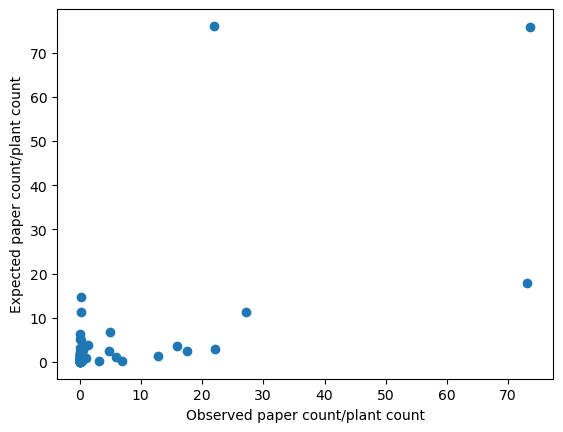

In [175]:
plt.scatter(all_counts['obs_by_plant'], all_counts['exp_by_plant'])
plt.xlabel('Observed paper count/plant count')
plt.ylabel('Expected paper count/plant count')

In [176]:
pvals = []
chi_stats = []
for i, row in all_counts.iterrows():
    O1 = row.obs_by_plant
    O2 = all_counts['obs_by_plant'].sum() - O1
    E1 = row.exp_by_plant
    E2 = all_counts['exp_by_plant'].sum() - E1
    chi_stat = (O1-E1)**2/E1+(O2-E2)**2/E2
    chi_stats.append(chi_stat)
    pvals.append(chi2.sf(chi_stat, df=1)) # To the best of my knowledge, this is the python equivalent of pchisq (https://stackoverflow.com/a/20165482)

Now we need to apply a multiple-testing p-value correction:

In [177]:
corrected_pvals = false_discovery_control(pvals)

Determine whether the country is over or underrepresented:

In [178]:
all_counts['chistat'] = chi_stats
all_counts['pvals'] = pvals
all_counts['corrected_pvals'] = corrected_pvals
all_counts['overrep'] = (all_counts['obs_by_plant'] > all_counts['exp_by_plant']) & (all_counts['corrected_pvals'] < 0.05)
all_counts['underrep'] = (all_counts['obs_by_plant'] < all_counts['exp_by_plant']) & (all_counts['corrected_pvals'] < 0.05)

In [179]:
all_counts.head()

,conf_auth_count,iso_alpha,population,paper_count,plant_count,area_km2,exp_papers,normed_plant_count,scaled_normed_plant_count,exp_by_plant,obs_by_plant,chistat,pvals,corrected_pvals,overrep,underrep
0,36.0,ZAF,5.989388e+07,118.0,16.0,1.216437e+06,16.153849,1.315317e-05,5.341834,3.024027,22.089791,121.202358,3.450761e-28,8.281825e-27,True,False
1,14.0,USA,3.332876e+08,366.0,2.0,9.512162e+06,89.890260,2.102571e-07,5.005464,17.958426,73.120090,179.656120,5.761076e-41,4.147975e-39,True,False
5,5.0,FRA,6.797131e+07,80.0,1.0,6.448534e+05,18.332394,1.550740e-06,5.040302,3.637162,15.872066,41.515294,1.169524e-10,1.202939e-09,True,False
6,3.0,ESP,4.777834e+07,89.0,1.0,5.023083e+05,12.886192,1.990809e-06,5.051739,2.550843,17.617697,89.577367,2.948784e-21,4.246249e-20,True,False
7,3.0,IND,1.417173e+09,110.0,3.0,3.142890e+06,382.222685,9.545355e-07,5.024807,76.067135,21.891387,53.060325,3.234602e-13,3.881523e-12,False,True


Add back countries we couldn't test because of a 0 plant count:

In [180]:
excluded_countries['overrep'] = excluded_countries['paper_count'] > 0
excluded_countries['underrep'] = False
excluded_countries.head()

,conf_auth_count,iso_alpha,population,paper_count,plant_count,area_km2,overrep,underrep
2,8.0,ISR,9557500.0,28.0,0.0,22975.676395,True,False
3,7.0,NLD,17700982.0,57.0,0.0,40021.326428,True,False
4,7.0,DEU,83797985.0,155.0,0.0,357425.257834,True,False
9,3.0,POL,36821749.0,81.0,0.0,310396.851155,True,False
11,2.0,AUT,9041851.0,32.0,0.0,85063.014795,True,False


In [181]:
all_counts_all_countries = all_counts.merge(excluded_countries, on=excluded_countries.columns.tolist(), how='outer')
all_counts_all_countries.tail()

,conf_auth_count,iso_alpha,population,paper_count,plant_count,area_km2,exp_papers,normed_plant_count,scaled_normed_plant_count,exp_by_plant,obs_by_plant,chistat,pvals,corrected_pvals,overrep,underrep
193,0.0,NRU,12668.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
194,0.0,TUV,11312.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
195,0.0,MUS,1262523.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
196,0.0,COM,836774.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
197,0.0,DN1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


Now we want to make a map, with the following colors:
* Significantly overrepresented
* Untested but overrepresented (0 plant count but has papers)
* Significantly underrepresented
* Properly represented

In [182]:
def get_category(row):
    if np.isnan(row.corrected_pvals) and row.overrep:
        return 'Overrepresented (no p-value)'
    elif not row.overrep and not row.underrep:
        return 'Correctly represented'
    elif (row.corrected_pvals is not None) and row.overrep and not row.underrep:
        return 'Overrepresented (significant)'
    elif (row.corrected_pvals is not None) and not row.overrep and row.underrep:
        return 'Underrepresented (significant)'

colors = ['#D81B60', '#FFC107', '#AFAFAF', '#AD1EE5']

In [183]:
all_counts_all_countries['category'] = all_counts_all_countries.apply(get_category, axis=1)

In [184]:
all_counts_all_countries.head()

,conf_auth_count,iso_alpha,population,paper_count,plant_count,area_km2,exp_papers,normed_plant_count,scaled_normed_plant_count,exp_by_plant,obs_by_plant,chistat,pvals,corrected_pvals,overrep,underrep,category
0,36.0,ZAF,5.989388e+07,118.0,16.0,1.216437e+06,16.153849,1.315317e-05,5.341834,3.024027,22.089791,121.202358,3.450761e-28,8.281825e-27,True,False,Overrepresented (significant)
1,14.0,USA,3.332876e+08,366.0,2.0,9.512162e+06,89.890260,2.102571e-07,5.005464,17.958426,73.120090,179.656120,5.761076e-41,4.147975e-39,True,False,Overrepresented (significant)
2,5.0,FRA,6.797131e+07,80.0,1.0,6.448534e+05,18.332394,1.550740e-06,5.040302,3.637162,15.872066,41.515294,1.169524e-10,1.202939e-09,True,False,Overrepresented (significant)
3,3.0,ESP,4.777834e+07,89.0,1.0,5.023083e+05,12.886192,1.990809e-06,5.051739,2.550843,17.617697,89.577367,2.948784e-21,4.246249e-20,True,False,Overrepresented (significant)
4,3.0,IND,1.417173e+09,110.0,3.0,3.142890e+06,382.222685,9.545355e-07,5.024807,76.067135,21.891387,53.060325,3.234602e-13,3.881523e-12,False,True,Underrepresented (significant)


In [185]:
fig = px.choropleth(all_counts_all_countries, locations='iso_alpha', color='category', color_discrete_sequence=colors)
fig.show()